De code voor het SVM gedeelte van de opdracht

Shape of dataset: (139, 494)
Columns: ['PREDICT_original_sf_compactness_avg_2.5D', 'PREDICT_original_sf_compactness_std_2.5D', 'PREDICT_original_sf_rad_dist_avg_2.5D', 'PREDICT_original_sf_rad_dist_std_2.5D', 'PREDICT_original_sf_roughness_avg_2.5D', 'PREDICT_original_sf_roughness_std_2.5D', 'PREDICT_original_sf_convexity_avg_2.5D', 'PREDICT_original_sf_convexity_std_2.5D', 'PREDICT_original_sf_cvar_avg_2.5D', 'PREDICT_original_sf_cvar_std_2.5D', 'PREDICT_original_sf_prax_avg_2.5D', 'PREDICT_original_sf_prax_std_2.5D', 'PREDICT_original_sf_evar_avg_2.5D', 'PREDICT_original_sf_evar_std_2.5D', 'PREDICT_original_sf_solidity_avg_2.5D', 'PREDICT_original_sf_solidity_std_2.5D', 'PREDICT_original_sf_area_avg_2.5D', 'PREDICT_original_sf_area_max_2.5D', 'PREDICT_original_sf_area_min_2.5D', 'PREDICT_original_sf_area_std_2.5D', 'PREDICT_original_sf_volume_2.5D', 'PREDICT_original_of_theta_x', 'PREDICT_original_of_theta_y', 'PREDICT_original_of_theta_z', 'PREDICT_original_hf_min', 'PREDICT_origina

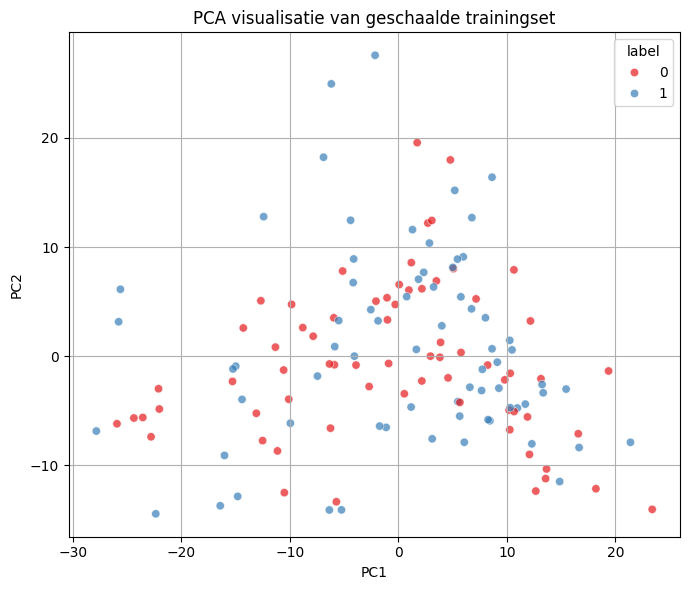

In [86]:
! pip install openpyxl
# 📦 Import standard libraries
import pandas as pd
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, f_classif, RFECV
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold, train_test_split, cross_validate
from sklearn.metrics import make_scorer, accuracy_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
# Definieer input_dir als een geldig pad
input_dir = os.getcwd()  # Gebruik de huidige werkdirectory of pas dit aan naar jouw map

# Maak het volledige pad naar TrainData.xlsx
train_dir = os.path.join(input_dir, 'TrainData.xlsx')  # Vervang .csv door .xlsx

# Lees het Excel-bestand
train_data = pd.read_excel(train_dir)  # Zorg ervoor dat openpyxl is geïnstalleerd # Adjust delimiter if necessary

# 🔎 Step 2: Inspect the dataset
print("Shape of dataset:", train_data.shape)
print("Columns:", train_data.columns.tolist())
print("First few rows:")
print(train_data.head())

# 🎯 Step 3: Separate features and labels
X_train = train_data.drop(columns="label")  # replace "label" if your target column has a different name
y_train = train_data["label"]

# 🔁 Step 4: Encode labels if they are strings
if y.dtype == 'object':
    label_encoder = LabelEncoder()
    y = pd.Series(label_encoder.fit_transform(y), index=y.index)
    print("Classes:", label_encoder.classes_)

# 📊 Evaluatie via meerdere metrics
scoring = {
    'accuracy': make_scorer(accuracy_score),
    'f1': make_scorer(f1_score),
    'roc_auc': 'roc_auc'
}

# 🔁 Vergelijking van scalers
scalers = {
    'StandardScaler': StandardScaler(),
    'MinMaxScaler': MinMaxScaler(),
    'RobustScaler': RobustScaler()
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
results = {}

for name, scaler in scalers.items():
    X_train_scaled_tmp = scaler.fit_transform(X_train)
    model = RandomForestClassifier(n_estimators=100, random_state=42)
    scores = cross_validate(model, X_train_scaled_tmp, y_train, cv=cv, scoring=scoring)

    results[name] = {
        'mean_accuracy': np.mean(scores['test_accuracy']),
        'mean_f1': np.mean(scores['test_f1']),
        'mean_auc': np.mean(scores['test_roc_auc'])
    }

# 📋 Print overzicht
print("\n🔍 Vergelijking van scalers op basis van Accuracy, F1 en ROC AUC:")
for name, res in results.items():
    print(f"{name}: Accuracy = {res['mean_accuracy']:.3f}, "
          f"F1 = {res['mean_f1']:.3f}, "
          f"AUC = {res['mean_auc']:.3f}")

# ✅ Beste scaler kiezen op basis van AUC (pas dit aan naar 'mean_f1' of 'mean_accuracy' indien gewenst)
best_scaler_name = max(results.items(), key=lambda x: x[1]['mean_auc'])[0]
print(f"\n✅ Beste scaler op basis van AUC: {best_scaler_name}")

# 🔁 Gebruik de beste scaler voor de rest van de pipeline
scaler = scalers[best_scaler_name]
X_train_scaled = scaler.fit_transform(X_train)

# ⚖️ Stap 6 – Balans controleren
print("\nLabelverdeling in training set:\n", y_train.value_counts(normalize=True))

# 📉 Stap 7 – PCA visualisatie (alleen op trainingset)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_train_scaled)
pca_df = pd.DataFrame(X_pca, columns=["PC1", "PC2"])
pca_df["label"] = y_train.values  # y_train is een Series, dus .values werkt nu

plt.figure(figsize=(7, 6))
sns.scatterplot(data=pca_df, x="PC1", y="PC2", hue="label", palette="Set1", alpha=0.7)
plt.title("PCA visualisatie van geschaalde trainingset")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.grid(True)
plt.tight_layout()
plt.show()


In [1]:
# Create the RFE object and compute a cross-validated score.
from sklearn import svm, feature_selection, model_selection

svc = svm.SVC(kernel="linear")

# classifications
rfecv = feature_selection.RFECV(
    estimator=svc, step=1,
    cv=model_selection.StratifiedKFold(10),
    scoring='roc_auc')
rfecv.fit(X_train_scaled, y_train)

# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(rfecv.cv_results_["mean_test_score"]) + 1), rfecv.cv_results_["mean_test_score"])
plt.show()

print("Optimal number of features:", rfecv.n_features_)
print("Selected features:", rfecv.support_)
print("Feature ranking:", rfecv.ranking_)

X_selected = X_train_scaled[:, rfecv.support_]
print(X_selected)

NameError: name 'X_train_scaled' is not defined

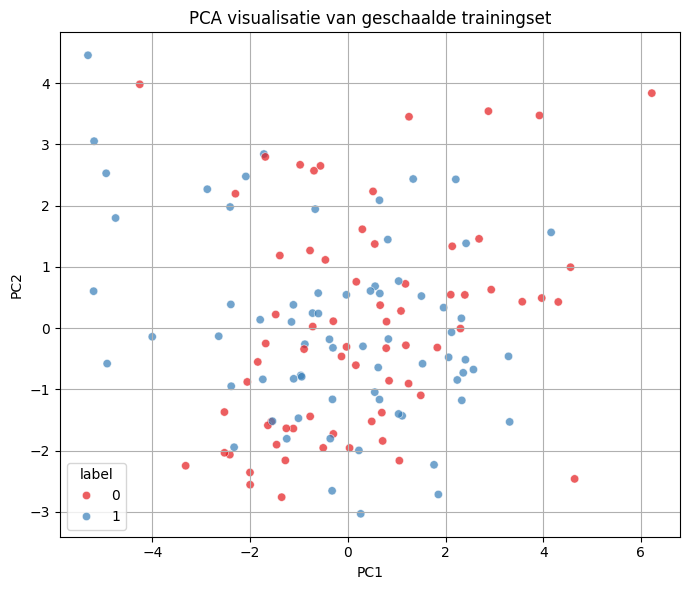

In [66]:
pca = PCA(n_components=19)
X_pca = pca.fit_transform(X_selected)
pca_df = pd.DataFrame(X_pca, columns=["PC1", "PC2", "PC3", "PC4", "PC5", "PC6", "PC7", "PC8", "PC9", "PC10",
                 "PC11", "PC12", "PC13", "PC14", "PC15", "PC16", "PC17", "PC18", "PC19"])
pca_df["label"] = y_train.values  # y_train is een Series, dus .values werkt nu

plt.figure(figsize=(7, 6))
sns.scatterplot(data=pca_df, x="PC1", y="PC2", hue="label", palette="Set1", alpha=0.7)
plt.title("PCA visualisatie van geschaalde trainingset")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.grid(True)
plt.tight_layout()
plt.show()

Shape of dataset: (139, 494)
Columns: ['PREDICT_original_sf_compactness_avg_2.5D', 'PREDICT_original_sf_compactness_std_2.5D', 'PREDICT_original_sf_rad_dist_avg_2.5D', 'PREDICT_original_sf_rad_dist_std_2.5D', 'PREDICT_original_sf_roughness_avg_2.5D', 'PREDICT_original_sf_roughness_std_2.5D', 'PREDICT_original_sf_convexity_avg_2.5D', 'PREDICT_original_sf_convexity_std_2.5D', 'PREDICT_original_sf_cvar_avg_2.5D', 'PREDICT_original_sf_cvar_std_2.5D', 'PREDICT_original_sf_prax_avg_2.5D', 'PREDICT_original_sf_prax_std_2.5D', 'PREDICT_original_sf_evar_avg_2.5D', 'PREDICT_original_sf_evar_std_2.5D', 'PREDICT_original_sf_solidity_avg_2.5D', 'PREDICT_original_sf_solidity_std_2.5D', 'PREDICT_original_sf_area_avg_2.5D', 'PREDICT_original_sf_area_max_2.5D', 'PREDICT_original_sf_area_min_2.5D', 'PREDICT_original_sf_area_std_2.5D', 'PREDICT_original_sf_volume_2.5D', 'PREDICT_original_of_theta_x', 'PREDICT_original_of_theta_y', 'PREDICT_original_of_theta_z', 'PREDICT_original_hf_min', 'PREDICT_origina

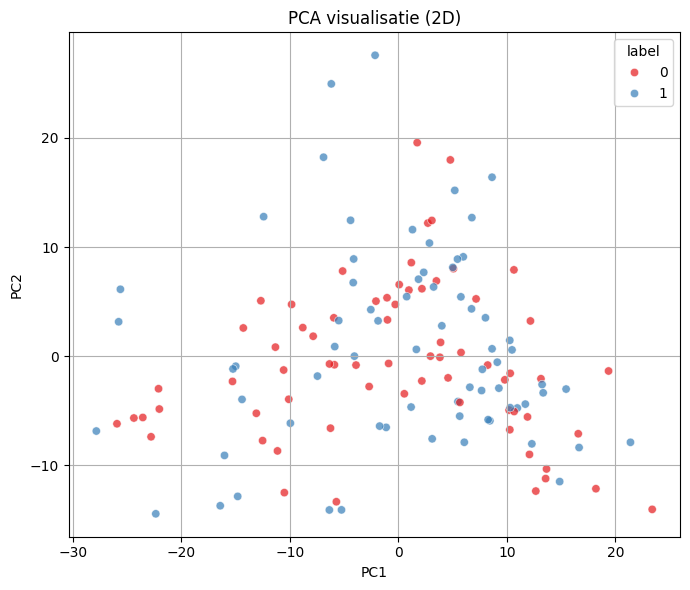

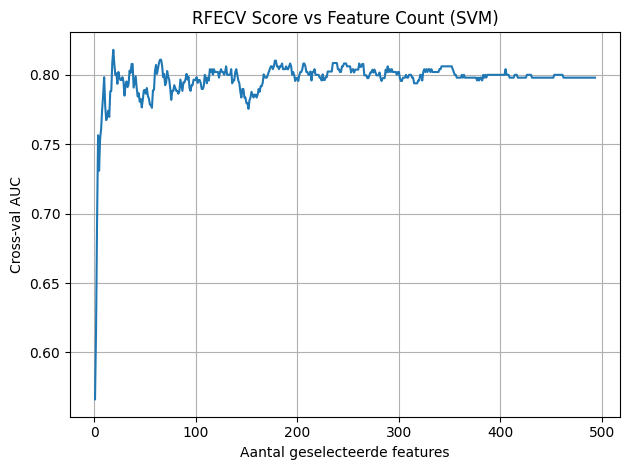

Optimal number of features: 19
Feature mask (True = geselecteerd): [False False False False False False False False  True False False False
 False False False  True False False False False False False False False
 False False False False False False False False False False False False
 False False False False  True False False  True  True False False False
 False  True False False False False False False False False False False
 False False False False False False False False False False  True False
 False False False False False False False False False False False False
 False False False False  True False False False  True False False False
 False False False False  True False False False  True False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False  True False False False False False
 False False False False False False False False False Fa

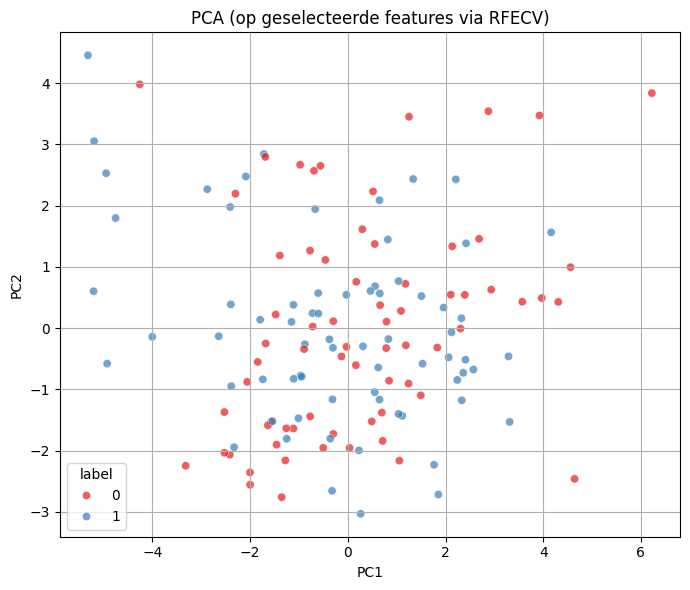

In [67]:
# 📦 Install OpenPyXL (alleen nodig in notebooks of bij eerste keer)
# !pip install openpyxl

# 📦 Imports
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler, RobustScaler
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, f_classif, RFECV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import make_scorer, accuracy_score, f1_score
from sklearn import svm, feature_selection, model_selection

# 📥 Laad de data
input_dir = os.getcwd()
train_path = os.path.join(input_dir, 'TrainData.xlsx')
train_data = pd.read_excel(train_path)

# 🔎 Inspectie
print("Shape of dataset:", train_data.shape)
print("Columns:", train_data.columns.tolist())
print(train_data.head())

# 🎯 Split X en y
X_train = train_data.drop(columns="label")
y_train = train_data["label"]

# 🏷️ Encode labels als nodig
if y_train.dtype == 'object':
    label_encoder = LabelEncoder()
    y_train = pd.Series(label_encoder.fit_transform(y_train), index=y_train.index)
    print("Label classes:", label_encoder.classes_)

# 📊 Scoring setup
scoring = {
    'accuracy': make_scorer(accuracy_score),
    'f1': make_scorer(f1_score),
    'roc_auc': 'roc_auc'
}

# 🔁 Vergelijk scalers
scalers = {
    'StandardScaler': StandardScaler(),
    'MinMaxScaler': MinMaxScaler(),
    'RobustScaler': RobustScaler()
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
results = {}

for name, scaler in scalers.items():
    X_scaled_tmp = scaler.fit_transform(X_train)
    model = RandomForestClassifier(n_estimators=100, random_state=42)
    scores = cross_validate(model, X_scaled_tmp, y_train, cv=cv, scoring=scoring)

    results[name] = {
        'mean_accuracy': np.mean(scores['test_accuracy']),
        'mean_f1': np.mean(scores['test_f1']),
        'mean_auc': np.mean(scores['test_roc_auc'])
    }

# 📋 Resultaten
print("\n🔍 Vergelijking van scalers:")
for name, res in results.items():
    print(f"{name}: Accuracy = {res['mean_accuracy']:.3f}, F1 = {res['mean_f1']:.3f}, AUC = {res['mean_auc']:.3f}")

# ✅ Beste scaler kiezen
best_scaler_name = max(results.items(), key=lambda x: x[1]['mean_auc'])[0]
scaler = scalers[best_scaler_name]
print(f"\n✅ Beste scaler: {best_scaler_name}")
X_train_scaled = scaler.fit_transform(X_train)

# ⚖️ Verdeling
print("\nLabelverdeling:\n", y_train.value_counts(normalize=True))

# 📉 PCA visualisatie (eerste 2 componenten)
pca_2 = PCA(n_components=2)
X_pca_2 = pca_2.fit_transform(X_train_scaled)
pca_df = pd.DataFrame(X_pca_2, columns=["PC1", "PC2"])
pca_df["label"] = y_train.values

plt.figure(figsize=(7, 6))
sns.scatterplot(data=pca_df, x="PC1", y="PC2", hue="label", palette="Set1", alpha=0.7)
plt.title("PCA visualisatie (2D)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.grid(True)
plt.tight_layout()
plt.show()

# 🔍 RFECV met SVM
svc = svm.SVC(kernel="linear")
rfecv = RFECV(estimator=svc, step=1, cv=StratifiedKFold(10), scoring='roc_auc')
rfecv.fit(X_train_scaled, y_train)

# Plot RFECV score
plt.figure()
plt.xlabel("Aantal geselecteerde features")
plt.ylabel("Cross-val AUC")
plt.plot(range(1, len(rfecv.cv_results_["mean_test_score"]) + 1), rfecv.cv_results_["mean_test_score"])
plt.title("RFECV Score vs Feature Count (SVM)")
plt.grid(True)
plt.tight_layout()
plt.show()

# ✅ Resultaten RFECV
print("Optimal number of features:", rfecv.n_features_)
print("Feature mask (True = geselecteerd):", rfecv.support_)
print("Feature ranking (1 = top feature):", rfecv.ranking_)

# 🔁 Selecteer features
X_selected = X_train_scaled[:, rfecv.support_]

# 📈 PCA opnieuw, maar nu op geselecteerde features (19 componenten)
pca_full = PCA(n_components=19)
X_pca_full = pca_full.fit_transform(X_selected)

# Zet om naar DataFrame voor visualisatie
pca_columns = [f"PC{i+1}" for i in range(19)]
pca_df_full = pd.DataFrame(X_pca_full, columns=pca_columns)
pca_df_full["label"] = y_train.values

# Visualisatie van PC1 vs PC2 (op geselecteerde features)
plt.figure(figsize=(7, 6))
sns.scatterplot(data=pca_df_full, x="PC1", y="PC2", hue="label", palette="Set1", alpha=0.7)
plt.title("PCA (op geselecteerde features via RFECV)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.grid(True)
plt.tight_layout()
plt.show()


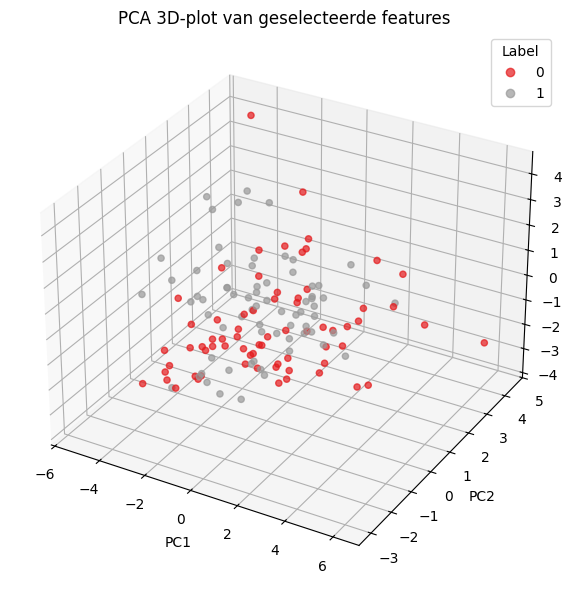

In [70]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# PCA op 3 componenten
pca = PCA(n_components=3)
X_pca_3d = pca.fit_transform(X_selected)

# 3D plot
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(
    X_pca_3d[:, 0], X_pca_3d[:, 1], X_pca_3d[:, 2],
    c=y_train, cmap='Set1', alpha=0.7
)
ax.set_title("PCA 3D-plot van geselecteerde features")
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_zlabel("PC3")
plt.legend(*scatter.legend_elements(), title="Label")
plt.tight_layout()
plt.show()


In [76]:
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC

# Gebruik de 19 geselecteerde features (X_selected)
svm = SVC(kernel='rbf', probability=True, C=grid_svm.best_params_['C'], gamma=grid_svm.best_params_['gamma'])

# 5-fold cross-validated AUC
auc_scores = cross_val_score(svm, X_selected, y_train, cv=10, scoring='roc_auc')
print(f"🔍 Gemiddelde ROC AUC: {np.mean(auc_scores):.3f} ± {np.std(auc_scores):.3f}")


🔍 Gemiddelde ROC AUC: 0.957 ± 0.041


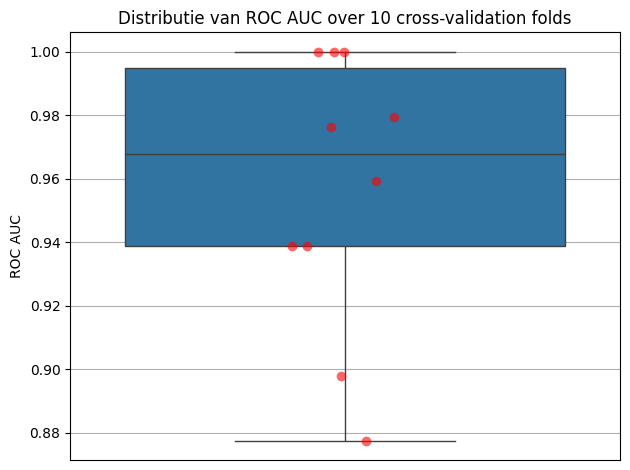

In [80]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.boxplot(data=auc_scores)
sns.stripplot(data=auc_scores, color='red', size=7, alpha=0.6)
plt.title("Distributie van ROC AUC over 10 cross-validation folds")
plt.ylabel("ROC AUC")
plt.xticks([])
plt.grid(True)
plt.tight_layout()
plt.show()


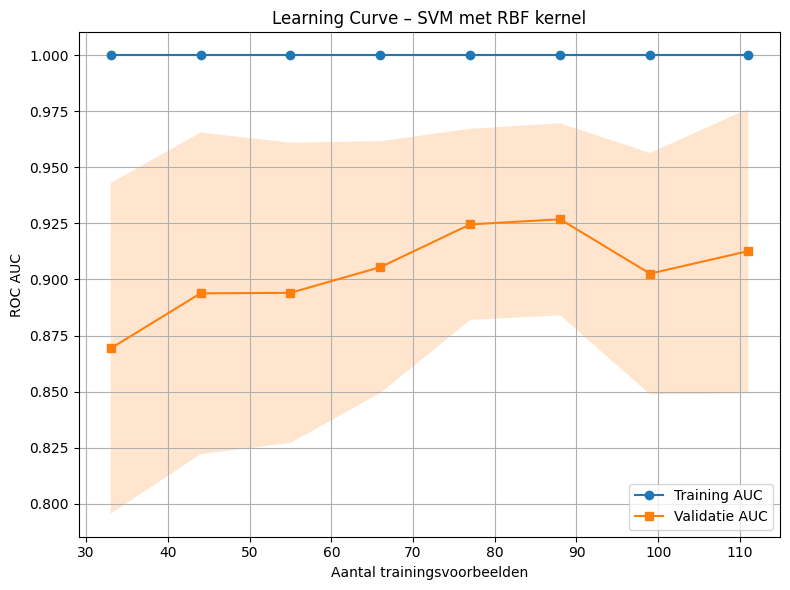

In [81]:
from sklearn.svm import SVC
from sklearn.model_selection import learning_curve
import numpy as np
import matplotlib.pyplot as plt

# Gebruik je getunede parameters hier
best_svm = SVC(kernel='rbf', C=10, gamma='scale', probability=True)

# Learning curve berekening
train_sizes, train_scores, val_scores = learning_curve(
    best_svm, X_selected, y_train,
    cv=5,
    scoring='roc_auc',
    train_sizes=np.linspace(0.3, 1.0, 8),  # Start vanaf 30%
    n_jobs=-1,
    error_score='raise'  # Debuggen indien gewenst
)


# Gemiddelde en standaarddeviatie berekenen
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
val_scores_mean = np.mean(val_scores, axis=1)
val_scores_std = np.std(val_scores, axis=1)

# Plotten
plt.figure(figsize=(8, 6))
plt.plot(train_sizes, train_scores_mean, label="Training AUC", marker='o')
plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2)

plt.plot(train_sizes, val_scores_mean, label="Validatie AUC", marker='s')
plt.fill_between(train_sizes, val_scores_mean - val_scores_std,
                 val_scores_mean + val_scores_std, alpha=0.2)

plt.title("Learning Curve – SVM met RBF kernel")
plt.xlabel("Aantal trainingsvoorbeelden")
plt.ylabel("ROC AUC")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()


In [85]:
# 📦 Imports
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.feature_selection import RFECV
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC

# 📥 Laad je trainingsdata
df = pd.read_excel("TrainData.xlsx")  # ← Pas pad aan indien nodig
X = df.drop(columns="label")
y = df["label"]
y = LabelEncoder().fit_transform(y)

# 🔁 Outer en inner CV splits
outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
inner_cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

# ⚙️ Pipeline: Scaling → RFECV → SVM
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('feature_selection', RFECV(
        estimator=SVC(kernel='linear'),
        step=1,
        cv=StratifiedKFold(n_splits=3),
        scoring='roc_auc',
        n_jobs=-1
    )),
    ('classifier', SVC(probability=True))
])

# 🔍 Hyperparameter grid voor SVM
param_grid = {
    'classifier__kernel': ['linear', 'rbf'],
    'classifier__C': [0.1, 1, 10, 100],
    'classifier__gamma': ['scale', 0.1, 0.01]  # alleen relevant voor RBF
}

# 🔬 Inner loop met GridSearch
grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    scoring='roc_auc',
    cv=inner_cv,
    n_jobs=-1
)

# 🧪 Outer loop: nested CV
nested_scores = cross_val_score(
    grid_search,
    X, y,
    cv=outer_cv,
    scoring='roc_auc',
    n_jobs=-1
)

# 📊 Resultaat
print(f"✅ Nested CV AUC: {np.mean(nested_scores):.3f} ± {np.std(nested_scores):.3f}")


KeyboardInterrupt: 

✅ Aantal geselecteerde features via RFE: 12


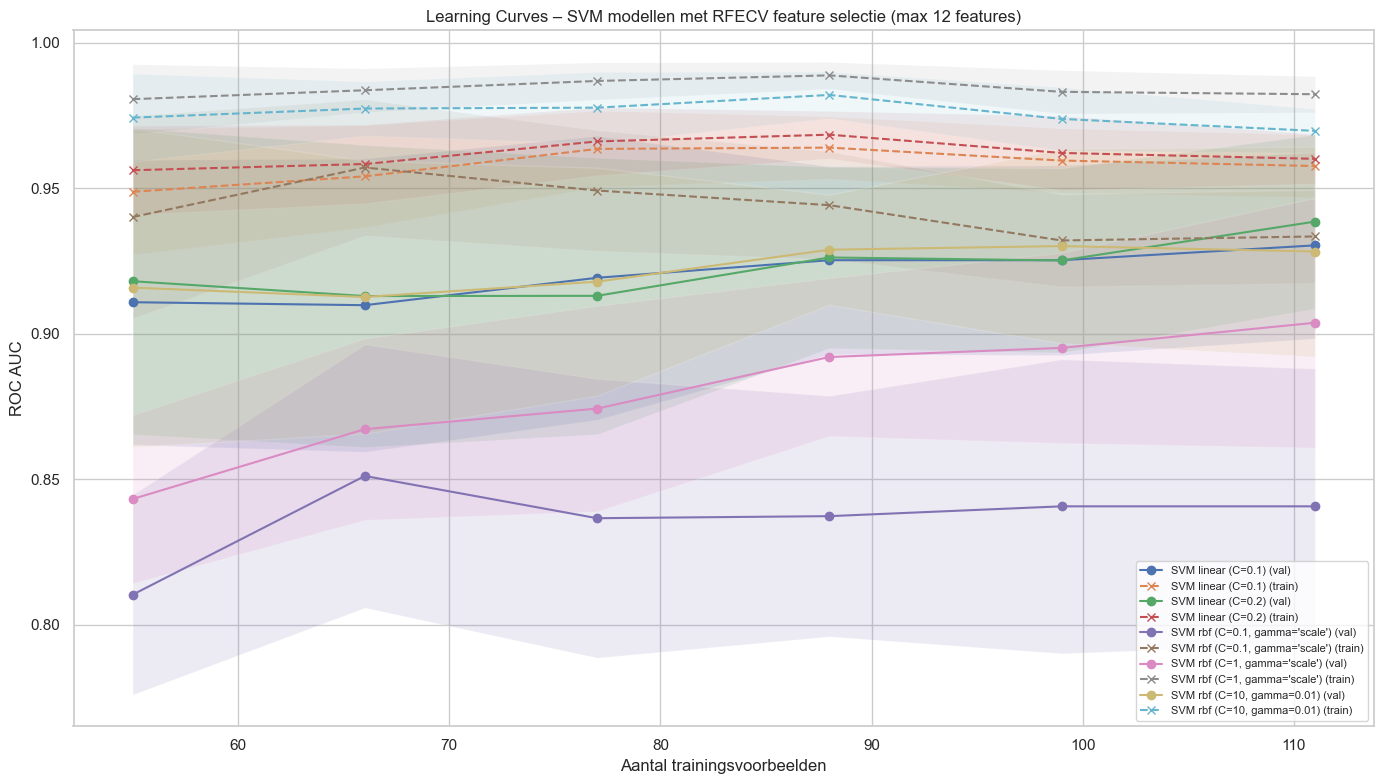


📊 Resultaten over 5-fold nested CV (max 12 features):
Mean Accuracy: 0.712 ± 0.084
Mean Roc_auc: 0.712 ± 0.083
Mean F1: 0.711 ± 0.079


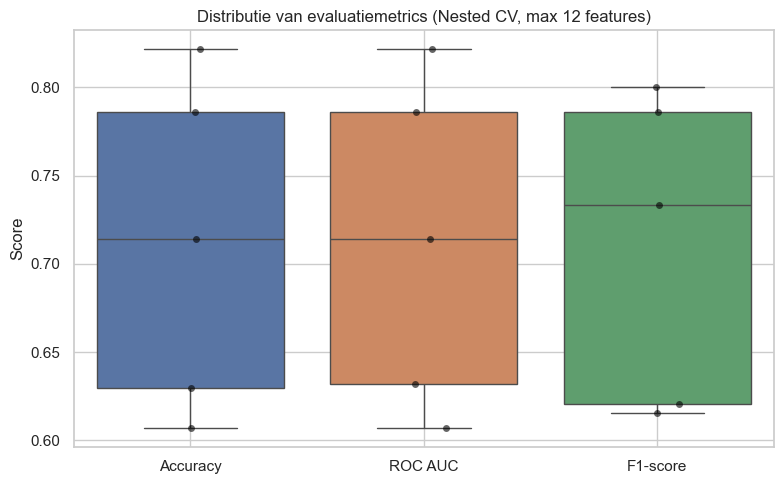

In [28]:
# 📦 Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold, learning_curve, cross_validate
from sklearn.feature_selection import RFE
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import make_scorer, accuracy_score, roc_auc_score, f1_score

# 📥 Data inladen
df = pd.read_excel("TrainData.xlsx")
X = df.drop(columns="label")
y = df["label"]
if y.dtype == 'object':
    y = LabelEncoder().fit_transform(y)

# ⚖️ Schalen
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 🔍 RFECV met max 12 features
selector = RFE(
    estimator=SVC(kernel='linear'),
    n_features_to_select=12,
    step=5
)
selector.fit(X_scaled, y)
X_selected = selector.transform(X_scaled)
print(f"✅ Aantal geselecteerde features via RFE: {X_selected.shape[1]}")


# 🔁 SVM modellen om te vergelijken
model_configs = {
    "SVM linear (C=0.1)": SVC(kernel='linear', C=0.1, probability=True),
    "SVM linear (C=0.2)": SVC(kernel='linear', C=0.2, probability=True),
    "SVM rbf (C=0.1, gamma='scale')": SVC(kernel='rbf', C=0.1, gamma='scale', probability=True),
    "SVM rbf (C=1, gamma='scale')": SVC(kernel='rbf', C=1, gamma='scale', probability=True),
    "SVM rbf (C=10, gamma=0.01)": SVC(kernel='rbf', C=10, gamma=0.01, probability=True),
}

# 📈 Learning curves
train_sizes = np.linspace(0.5, 1.0, 6)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
plt.figure(figsize=(14, 8))

for label, model in model_configs.items():
    sizes, train_scores, val_scores = learning_curve(
        model, X_selected, y,
        train_sizes=train_sizes,
        cv=cv,
        scoring='roc_auc',
        n_jobs=-1
    )
    plt.plot(sizes, np.mean(val_scores, axis=1), label=f"{label} (val)", marker='o')
    plt.fill_between(sizes, 
                     np.mean(val_scores, axis=1) - np.std(val_scores, axis=1),
                     np.mean(val_scores, axis=1) + np.std(val_scores, axis=1), alpha=0.15)
    plt.plot(sizes, np.mean(train_scores, axis=1), label=f"{label} (train)", linestyle='--', marker='x')
    plt.fill_between(sizes, 
                     np.mean(train_scores, axis=1) - np.std(train_scores, axis=1),
                     np.mean(train_scores, axis=1) + np.std(train_scores, axis=1), alpha=0.1)

plt.title("Learning Curves – SVM modellen met RFECV feature selectie (max 12 features)")
plt.xlabel("Aantal trainingsvoorbeelden")
plt.ylabel("ROC AUC")
plt.grid(True)
plt.legend(loc="lower right", fontsize=8)
plt.tight_layout()
plt.show()

# 🧪 Nested Cross Validation voor beste model
best_model = SVC(kernel='linear', C=0.1, probability=True)
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('feature_selection', RFE(
    estimator=SVC(kernel='linear'),
    n_features_to_select=12,
    step=5
    )),

    ('clf', best_model)
])

outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scoring = {
    'accuracy': make_scorer(accuracy_score),
    'roc_auc': make_scorer(roc_auc_score),
    'f1': make_scorer(f1_score)
}
cv_results = cross_validate(
    estimator=pipeline,
    X=X,
    y=y,
    scoring=scoring,
    cv=outer_cv,
    return_train_score=False,
    n_jobs=-1
)

print("\n📊 Resultaten over 5-fold nested CV (max 12 features):")
for metric in scoring.keys():
    scores = cv_results[f'test_{metric}']
    print(f"Mean {metric.capitalize()}: {np.mean(scores):.3f} ± {np.std(scores):.3f}")

# 📊 Boxplot van evaluatiemetrics
df_metrics = pd.DataFrame({
    'Accuracy': cv_results['test_accuracy'],
    'ROC AUC': cv_results['test_roc_auc'],
    'F1-score': cv_results['test_f1']
})

plt.figure(figsize=(8, 5))
sns.boxplot(data=df_metrics)
sns.stripplot(data=df_metrics, color='black', size=5, alpha=0.6)
plt.title("Distributie van evaluatiemetrics (Nested CV, max 12 features)")
plt.ylabel("Score")
plt.grid(True)
plt.tight_layout()
plt.show()


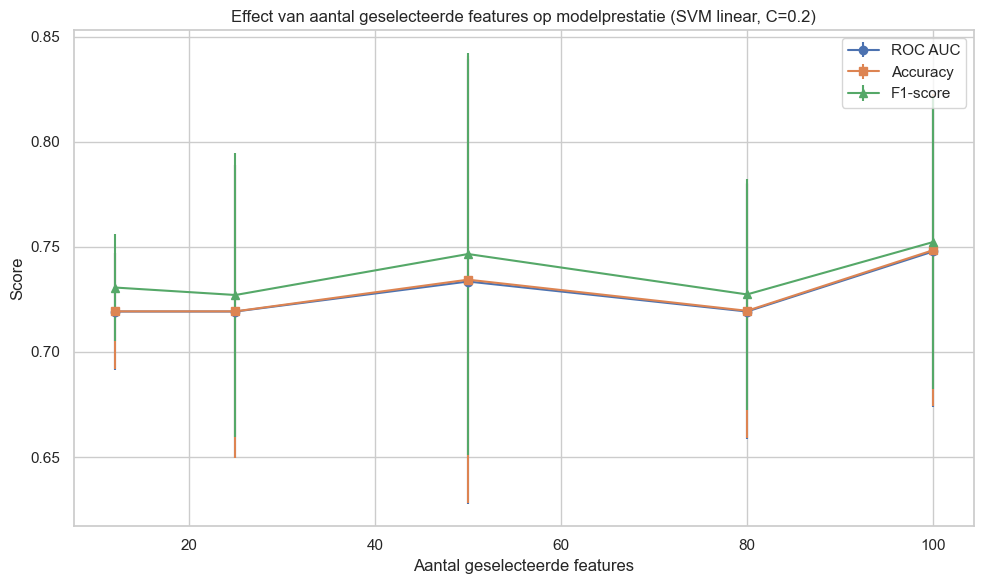

In [29]:
# 📦 Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import RFE
from sklearn.metrics import make_scorer, accuracy_score, roc_auc_score, f1_score

# 1️⃣ DATA INLADEN EN VOORBEWERKING
df = pd.read_excel("TrainData.xlsx")  # <-- Zet pad juist indien nodig
X = df.drop(columns="label")
y = df["label"]
if y.dtype == 'object':
    y = LabelEncoder().fit_transform(y)

# 2️⃣ MODEL & CROSS VALIDATION-INSTELLINGEN
base_model = SVC(kernel="linear", C=0.2, probability=True)
outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scoring = {
    'accuracy': make_scorer(accuracy_score),
    'roc_auc': make_scorer(roc_auc_score),
    'f1': make_scorer(f1_score)
}
feature_counts = [12, 25, 50, 80, 100]

# 3️⃣ LOOP OVER AANTAL FEATURES MET RFE
results = []

for k in feature_counts:
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('feature_selection', RFE(estimator=SVC(kernel='linear'), n_features_to_select=k)),
        ('clf', base_model)
    ])
    
    scores = cross_validate(
        estimator=pipeline,
        X=X,
        y=y,
        scoring=scoring,
        cv=outer_cv,
        return_train_score=False,
        n_jobs=-1
    )
    
    results.append({
        "features": k,
        "accuracy_mean": np.mean(scores["test_accuracy"]),
        "accuracy_std": np.std(scores["test_accuracy"]),
        "roc_auc_mean": np.mean(scores["test_roc_auc"]),
        "roc_auc_std": np.std(scores["test_roc_auc"]),
        "f1_mean": np.mean(scores["test_f1"]),
        "f1_std": np.std(scores["test_f1"]),
    })

df_results = pd.DataFrame(results)

# 4️⃣ PLOT RESULTATEN
plt.figure(figsize=(10, 6))
plt.errorbar(df_results["features"], df_results["roc_auc_mean"], yerr=df_results["roc_auc_std"], label="ROC AUC", marker='o')
plt.errorbar(df_results["features"], df_results["accuracy_mean"], yerr=df_results["accuracy_std"], label="Accuracy", marker='s')
plt.errorbar(df_results["features"], df_results["f1_mean"], yerr=df_results["f1_std"], label="F1-score", marker='^')

plt.title("Effect van aantal geselecteerde features op modelprestatie (SVM linear, C=0.2)")
plt.xlabel("Aantal geselecteerde features")
plt.ylabel("Score")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


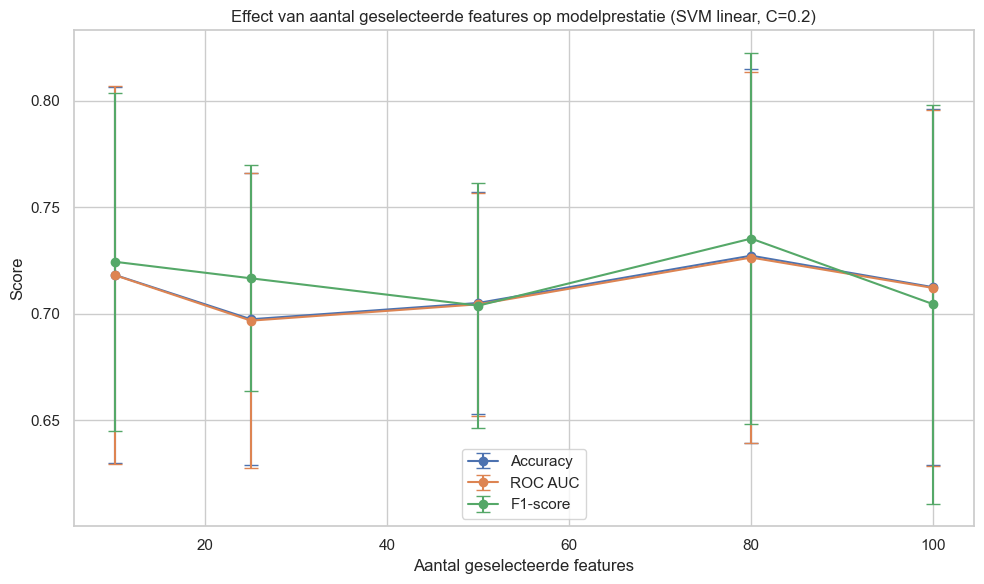

In [32]:
# 📊 Feature Selection Sweep (bugfix versie)
from sklearn.feature_selection import RFE
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_validate

feature_counts = [10, 25, 50, 80, 100]
mean_scores = {'accuracy': [], 'roc_auc': [], 'f1': []}
std_scores = {'accuracy': [], 'roc_auc': [], 'f1': []}

for k in feature_counts:
    selector = RFE(SVC(kernel="linear"), n_features_to_select=k, step=5)
    model = Pipeline([
        ('scaler', StandardScaler()),
        ('feature_selection', selector),
        ('clf', SVC(kernel="linear", C=0.2, probability=True))
    ])
    
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    scoring = {
        'accuracy': make_scorer(accuracy_score),
        'roc_auc': make_scorer(roc_auc_score),
        'f1': make_scorer(f1_score)
    }
    
    cv_result = cross_validate(model, X, y, scoring=scoring, cv=cv)
    for metric in scoring.keys():
        mean_scores[metric].append(np.mean(cv_result[f'test_{metric}']))
        std_scores[metric].append(np.std(cv_result[f'test_{metric}']))

# ✅ Visualisatie
plt.figure(figsize=(10, 6))
label_names = {
    'accuracy': 'Accuracy',
    'roc_auc': 'ROC AUC',
    'f1': 'F1-score'
}

for metric in mean_scores:
    plt.errorbar(feature_counts, mean_scores[metric], yerr=std_scores[metric],
                 label=label_names[metric], marker='o', capsize=5)

plt.title("Effect van aantal geselecteerde features op modelprestatie (SVM linear, C=0.2)")
plt.xlabel("Aantal geselecteerde features")
plt.ylabel("Score")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("feature_selection_sweep_C02.png", dpi=300)
plt.show()
